# **Avalanche Risk Project**

Advanced Data Analytics, Fall 2025

The following project examines the feasibility of deep learning models (3D-CNN, convLSTM) compared to traditional, state-of-the-art methods for predicting avalanche danger levels. Using a comprehensive dataset from the Swiss Federal Institute for Snow and Avalanche Research (SLF) spanning from 1997-2020, the project heavily relies on the work of Pérez-Guillén et al. (2022) and Maissen et al. (2024) and adopts many of their preprocessing and modeling techniques.

In [25]:
# Necessary Libraries 
import requests
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from bs4 import BeautifulSoup
import time

# **1. Preprocessing**

In [96]:
imis_df = pd.read_csv('data/data_rf1_forecast.csv')

In [97]:
imis_df

,Unnamed: 0,datum,station_code,sector_id,warnreg,elevation_station,forecast_initial_date,forecast_end_date,dangerLevel,elevation_th,...,ssi_pwl,sk38_pwl,sn38_pwl,ccl_pwl,ssi_pwl_100,sk38_pwl_100,sn38_pwl_100,ccl_pwl_100,Pen_depth,min_ccl_pen
0,0,1997-11-11,KES2,7113.0,15.0,2700.0,1997-11-11 17:00:00,1997-11-12 17:00:00,1.0,2000.0,...,2.02,1.02,1.92,0.30,2.02,1.02,1.92,0.30,44.028391,0.17
1,1,1997-11-11,SIM2,6113.0,15.0,2400.0,1997-11-11 17:00:00,1997-11-12 17:00:00,2.0,2000.0,...,6.00,6.00,6.00,4.00,6.00,6.00,6.00,4.00,37.271809,0.26
2,2,1997-11-11,DTR2,6113.0,15.0,2100.0,1997-11-11 17:00:00,1997-11-12 17:00:00,2.0,2000.0,...,1.44,0.44,1.37,0.12,1.44,0.44,1.37,0.12,38.369101,0.12
3,3,1997-11-11,MEI2,2221.0,15.0,2200.0,1997-11-11 17:00:00,1997-11-12 17:00:00,1.0,2000.0,...,6.00,6.00,6.00,0.20,6.00,6.00,6.00,0.20,20.400000,4.00
4,4,1997-11-11,SPN2,4232.0,15.0,2600.0,1997-11-11 17:00:00,1997-11-12 17:00:00,2.0,2000.0,...,6.00,6.00,6.00,4.00,6.00,6.00,6.00,4.00,42.332551,0.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292832,292832,2020-05-04,FIR2,1242.0,21.0,2100.0,2020-05-04 17:00:00,2020-05-05 17:00:00,2.0,1800.0,...,6.00,6.00,6.00,4.00,6.00,6.00,6.00,4.00,6.299643,3.00
292833,292833,2020-05-04,GRA2,1311.0,21.0,2000.0,2020-05-04 17:00:00,2020-05-05 17:00:00,2.0,1800.0,...,6.00,6.00,6.00,4.00,6.00,6.00,6.00,4.00,6.881834,3.00
292834,292834,2020-05-04,SHE2,1213.0,21.0,1900.0,2020-05-04 17:00:00,2020-05-05 17:00:00,2.0,1800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
292835,292835,2020-05-04,ELS2,1231.0,21.0,2100.0,2020-05-04 17:00:00,2020-05-05 17:00:00,2.0,1800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
# Remove Unnecessary Column
imis_df.drop(columns=['Unnamed: 0'], inplace=True)

As we can see, the coordinates of the IMIS weather stations are missing in this dataset. I add them from another dataset containing the coordinates of all IMIS stations in Switzerland.

In [99]:
stations_csv = pd.read_csv('data/stations.csv')
imis_stations = imis_df['station_code'].unique()

# Check which stations are in the CSV
csv_stations = stations_csv['station_code'].unique()
found_in_csv = [s for s in imis_stations if s in csv_stations]
not_in_csv = [s for s in imis_stations if s not in csv_stations]

# Merging 
imis_df = imis_df.merge(stations_csv[['station_code', 'lon', 'lat']], 
                         on='station_code', 
                         how='left')

if imis_df['lon'].isna().sum() > 0:
    still_missing = imis_df[imis_df['lon'].isna()]['station_code'].unique()
    print(f"\nStations STILL missing coordinates: {sorted(still_missing)}")

In [101]:
imis_df.columns

Index(['datum', 'station_code', 'sector_id', 'warnreg', 'elevation_station',
       'forecast_initial_date', 'forecast_end_date', 'dangerLevel',
       'elevation_th', 'set', 'Qs', 'Ql', 'TSG', 'Qg0', 'Qr', 'OLWR', 'ILWR',
       'LWR_net', 'OSWR', 'ISWR', 'Qw', 'pAlbedo', 'ISWR_h', 'ISWR_diff',
       'ISWR_dir', 'TA', 'TSS_mod', 'TSS_meas', 'T_bottom', 'RH', 'VW',
       'VW_drift', 'DW', 'MS_Snow', 'HS_mod', 'HS_meas', 'hoar_size',
       'wind_trans24', 'wind_trans24_7d', 'wind_trans24_3d', 'HN24', 'HN72_24',
       'HN24_7d', 'SWE', 'MS_water', 'MS_Wind', 'MS_Rain', 'MS_SN_Runoff',
       'MS_Sublimation', 'MS_Evap', 'TS0', 'TS1', 'TS2', 'Sclass2', 'zSd_mean',
       'Sd', 'zSn', 'Sn', 'zSs', 'Ss', 'zS4', 'S4', 'zS5', 'S5', 'pwl_100',
       'pwl_100_15', 'base_pwl', 'ssi_pwl', 'sk38_pwl', 'sn38_pwl', 'ccl_pwl',
       'ssi_pwl_100', 'sk38_pwl_100', 'sn38_pwl_100', 'ccl_pwl_100',
       'Pen_depth', 'min_ccl_pen', 'lon', 'lat'],
      dtype='object')

**Feature Table**

| Index | Variable Name         | Description                                                          |
| :---- | :-------------------- | :------------------------------------------------------------------- |
| 0     | `datum`                 | Date                                                                 |
| 1     | `station_code`          | Station Identifier                                                   |
| 2     | `sector_id`             | Sector ID                                                            |
| 3     | `warnreg`               | Warning Region ID                                                    |
| 4     | `elevation_station`     | Elevation of the station                                             |
| 5     | `forecast_initial_date` | Start date of the forecast validity                                  |
| 6     | `forecast_end_date`     | End date of the forecast validity                                    |
| 7     | `dangerLevel`           | Target variable: Forecast danger level                               |
| 8     | `elevation_th`          | Elevation threshold from the forecast                                |
| 9     | `set`                   | Data split identifier (e.g., train/test)                             |
| 10    | `Qs`                    | Sensible heat [$W m^{-2}$]                                            |
| 11    | `Ql`                    | Latent heat [$W m^{-2}$]                                              |
| 12    | `TSG`                   | Ground temperature [$^{\circ}C$]                                      |
| 13    | `Qg0`                   | Ground heat at soil interface [$W m^{-2}$]                            |
| 14    | `Qr`               | Rain energy [$W m^{-2}$]                                              |
| 15    | `OLWR`                  | Outgoing long-wave radiation [$W m^{-2}$]                             |
| 16    | `ILWR`                  | Incoming long-wave radiation [$W m^{-2}$]                             |
| 17    | `LWR_net`               | Net long-wave radiation [$W m^{-2}$]                                 |
| 18    | `OSWR`                  | Reflected short-wave radiation [$W m^{-2}$]                          |
| 19    | `ISWR`                  | Incoming short-wave radiation [$W m^{-2}$]                            |
| 20    | `Qw`                    | Net short-wave radiation [$W m^{-2}$]                                |
| 21    | `pAlbedo`               | Parametrized albedo [-]                                              |
| 22    | `ISWR_h`                | Incoming short wave on the horizontal [$W m^{-2}$]                    |
| 23    | `ISWR_diff`             | Diffuse incoming short wave [$W m^{-2}$]                              |
| 24    | `ISWR_dir`              | Direct incoming short wave [$W m^{-2}$]                               |
| 25    | `TA`                    | Air temperature [$^{\circ}C$]                                        |
| 26    | `TSS_mod`               | Surface temperature [$^{\circ}C$] (Modelled)                          |
| 27    | `TSS_meas`              | Surface temperature [$^{\circ}C$] (Measured)                          |
| 28    | `T_bottom`              | Bottom temperature [$^{\circ}C$]                                     |
| 29    | `RH`                    | Relative humidity [-]                                                |
| 30    | `VW`                    | Wind velocity [$m s^{-1}$]                                           |
| 31    | `VW_drift`              | Wind velocity drift [$m s^{-1}$]                                     |
| 32    | `DW`                    | Wind direction [$^{\circ}$]                                          |
| 33    | `MS_Snow`               | Solid precipitation rate [$kg s^{-2} h^{-1}$]                         |
| 34    | `HS_mod`                | Snow height [cm] (Modelled)                                          |
| 35    | `HS_meas`               | Snow height [cm] (Measured)                                          |
| 36    | `hoar_size`             | Hoar size [cm]                                                       |
| 37    | `wind_trans24`          | 24 h wind drift [cm]                                                 |
| 38    | `wind_trans24_7d`       | 7 d wind drift [cm]                                                  |
| 39    | `wind_trans24_3d`       | 3 d wind drift [cm]                                                  |
| 40    | `HN24`                  | 24 h height of new snow [cm]                                         |
| 41    | `HN72_24`               | 3 d sum of daily height of new snow [cm]                             |
| 42    | `HN24_7d`               | 7 d sum of daily height of new snow [cm]                             |
| 43    | `SWE`                   | Snow water equivalent [$kg m^{-2}$]                                  |
| 44    | `MS_water`              | Total amount of water [$kg m^{-2}$]                                  |
| 45    | `MS_Wind`               | Erosion mass loss [$kg m^{-2}$]                                      |
| 46    | `MS_Rain`               | Rain rate [$kg s^{-2} h^{-1}$]                                       |
| 47    | `MS_SN_Runoff`          | Virtual lysimeter [$kg s^{-2} h^{-1}$]                               |
| 48    | `MS_Sublimation`        | Sublimation mass [$kg m^{-2}$]                                       |
| 49    | `MS_Evap`               | Evaporated mass [$kg m^{-2}$]                                        |
| 50    | `TS0`                   | Snow temperature at 0.25 m [$^{\circ}C$]                              |
| 51    | `TS1`                   | Snow temperature at 0.5 m [$^{\circ}C$]                               |
| 52    | `TS2`                   | Snow temperature at 1 m [$^{\circ}C$]                                |
| 53    | `Sclass2`               | Stability class [-]                                                  |
| 54    | `zSd_mean`              | Mean depth of deformation rate stability index [cm]                  |
| 55    | `Sd`                    | Deformation rate stability index [-]                                 |
| 56    | `zSn`                   | Depth of natural stability index [cm]                                |
| 57    | `Sn`                    | Natural stability index [-]                                          |
| 58    | `zSs`                   | Depth of Sk38 skier stability index [m]                              |
| 59    | `Ss`                    | Sk38 skier stability index [-]                                       |
| 60    | `zS4`                   | Depth of structural stability index [cm]                             |
| 61    | `S4`                    | Structural stability index [-]                                       |
| 62    | `zS5`                   | Depth of stability index 5 [cm]                                      |
| 63    | `S5`                    | Stability index 5 [-]                                                |
| 64    | `pwl_100`               | Persistent weak layer(s) in the 100 cm from the surface [-]            |
| 65    | `pwl_100_15`            | Persistent weak layer(s) at depths between 15 and 100 cm [-]         |
| 66    | `base_pwl`              | Persistent weak layer at bottom [-]                                  |
| 67    | `ssi_pwl`               | Structural stability index at weak layer [-]                         |
| 68    | `sk38_pwl`              | Sk38 skier stability index at weak layer [-]                         |
| 69    | `sn38_pwl`              | Natural stability index at weak layer [-]                            |
| 70    | `ccl_pwl`               | Critical cut length at weak layer [m]                                |
| 71    | `ssi_pwl_100`           | Structural stability index at surface weak layer [-]                 |
| 72    | `sk38_pwl_100`          | Sk38 skier stability index at surface weak layer [-]                 |
| 73    | `sn38_pwl_100`          | Natural stability index at surface weak layer [-]                    |
| 74    | `ccl_pwl_100`           | Critical cut length at surface weak layer [m]                        |
| 75    | `Pen_depth`             | Skier penetration depth [cm]                                         |
| 76    | `min_ccl_pen`           | Min critical cut length at a deeper layer of the penetration depth [m] |
| 77    | `lon`                   | Longitude of the station                                            |
| 78    | `lat`                   | Latitude of the station                                             |

## **1.1 Data Quality & Imputation**

I start by checking for missing values in the dataset to understand the extent of data cleaning required.

In [102]:
# Missing Values
missing_values = pd.DataFrame(imis_df.isnull().sum(), columns=['Missing_Count'])
missing_values_df = missing_values[missing_values['Missing_Count'] > 0].sort_values(by='Missing_Count', ascending=False)
missing_values_df['Missing_Percentage'] = (missing_values_df['Missing_Count'] / len(imis_df)) * 100
missing_values_df

,Missing_Count,Missing_Percentage
elevation_th,33692,11.505377
TS2,30313,10.351492
TS1,28884,9.863508
TS0,25859,8.830510
Sd,15449,5.275631
Sn,15449,5.275631
S4,14185,4.843992
Ss,14185,4.843992
Pen_depth,11315,3.863924
min_ccl_pen,10986,3.751575


The missing value table reveals that several key features have significant missing value counts, particularly the snow temperature measurements (TS0, TS1, TS2) and stability indices (Sd, Sn, Ss).

In [103]:
# Analyze Missingness in elevation_th by dangerLevel
imis_df[imis_df['elevation_th'].isnull()].groupby('dangerLevel').size()

dangerLevel
1.0    32539
2.0      459
3.0      533
4.0      161
dtype: int64

The analysis above suggests the following:
- `elevation_th`: SLF guidelines state that if no threshold is given, "no particularly affected altitudes exist". This is particularly for Danger Level 1 often the case. We impute with 0 for all danger levels. 
- `TS0`, `TS1`, `TS2` and other temperatur-related measurements: The sensors require a minimum snow depth (often >100 cm) to provide valid temperatur readings. Regarding the high number and the low importance found in Pérez-Guillén et al. (2022), it is safe to drop these features.
- `Stability Indices` (`Sd`, `pwl` ...): In SNOWPACK simulations, these values are often undefined if the model cannot find a persistent weak layer (PWL). It therefore stands for high stability in the snowpack. I assign the maximum observed value for these indices to indicate the absence of a weak layer.
- `Pen_depth`: Missing often implies no snow or a very hard surface (penetration = 0). Impute missing values with 0.
- `pwl_100`, `base_pwl`, `pwl_100_15`: categorical features indicating the presence of a persistent weak layer in certain depth ranges. Due to high correlation with other stability indices, these features are dropped to avoid redundancy.
- Other features with low missingness (`Qg0`, `HN72_24`,`TA`, `HN24`, `TSS_mod`) are imputed by using temporal interpolation

In [104]:
# elevation_th imputation 
imis_df['elevation_th'] = imis_df['elevation_th'].fillna(0)

In [105]:
# Drop temperature measurements
imis_df.drop(columns=['TS0', 'TS1', 'TS2', 'TSG', 'TSS_meas', 'T_bottom'], inplace=True)

In [106]:
# Drop categorical pwl indicators
imis_df.drop(columns=['pwl_100', 'base_pwl', 'pwl_100_15'], inplace=True)

In [107]:
# Check value ranges for stability indices and PWL indicators
features_to_check = [
    'Sd', 'Sn', 'S4', 'Ss', 'S5',
    'min_ccl_pen', 'ccl_pwl', 'ccl_pwl_100',
    'sk38_pwl', 'sk38_pwl_100',
    'ssi_pwl', 'ssi_pwl_100',
    'sn38_pwl', 'sn38_pwl_100'
]

value_ranges = pd.DataFrame({
    'Feature': features_to_check,
    'Min': [imis_df[col].min() for col in features_to_check],
    'Max': [imis_df[col].max() for col in features_to_check],
    'Mean': [imis_df[col].mean() for col in features_to_check],
    'Median': [imis_df[col].median() for col in features_to_check],
    'Std': [imis_df[col].std() for col in features_to_check],
    'Missing_Count': [imis_df[col].isna().sum() for col in features_to_check],
    'Missing_Pct': [(imis_df[col].isna().sum() / len(imis_df) * 100) for col in features_to_check]
})

print("Value Ranges for Stability Indices:\n")
print(value_ranges.to_string(index=False))

Value Ranges for Stability Indices:

     Feature      Min      Max     Mean   Median      Std  Missing_Count  Missing_Pct
          Sd  0.10000 6.000000 0.818749 0.280500 1.186686          15449     5.275631
          Sn  0.20625 6.000000 2.220218 1.705000 1.508922          15449     5.275631
          S4  0.05000 6.000000 1.945472 1.886875 1.089957          14185     4.843992
          Ss  0.05000 6.000000 0.949618 0.684000 1.220140          14185     4.843992
          S5  0.00000 3.950125 0.142774 0.000000 0.327495           1782     0.608530
 min_ccl_pen -2.70000 4.000000 0.657081 0.360000 0.800285          10986     3.751575
     ccl_pwl -2.11000 4.000000 1.716146 0.600000 1.691620          10403     3.552488
 ccl_pwl_100 -2.11000 4.000000 1.797345 0.620000 1.720575          10403     3.552488
    sk38_pwl  0.05000 6.000000 2.882696 1.230000 2.611054          10371     3.541561
sk38_pwl_100  0.05000 6.000000 3.033212 1.340000 2.631071          10371     3.541561
     ssi_pwl  0.0

I impute the missing values based on the above analysis. However, the lower bounds for cut lengths (`ccl_pwl`, `ccl_pwl_100`, `min_ccl_pen`) are negative, which is not physically meaningful. Also, the range of `S5` is unexpected (dropped here as inPérez-Guillén et al. (2022)).

In [108]:
# Drop S5 due to unexpected range
imis_df.drop(columns=['S5'], inplace=True)

In [109]:
# Impute Stability Indices and PWL Indicators
stabilities_to_impute = [
    'Sd', 'Sn', 'S4', 'Ss',
    'sk38_pwl', 'sk38_pwl_100',
    'ssi_pwl', 'ssi_pwl_100',
    'sn38_pwl', 'sn38_pwl_100'
]

cut_lengths_to_impute = [
    'min_ccl_pen', 'ccl_pwl', 'ccl_pwl_100'
]

# Impute stability indices with their maximum value 
for col in stabilities_to_impute:
    max_value = imis_df[col].max()
    imis_df[col] = imis_df[col].fillna(max_value)

# Impute critical cut lengths with 4 (indicating very stable snowpack)
for col in cut_lengths_to_impute:
    imis_df[col] = imis_df[col].fillna(4.0)

# Impute Pen_depth with 0 (no snow or hard surface)
imis_df['Pen_depth'] = imis_df['Pen_depth'].fillna(0)
    

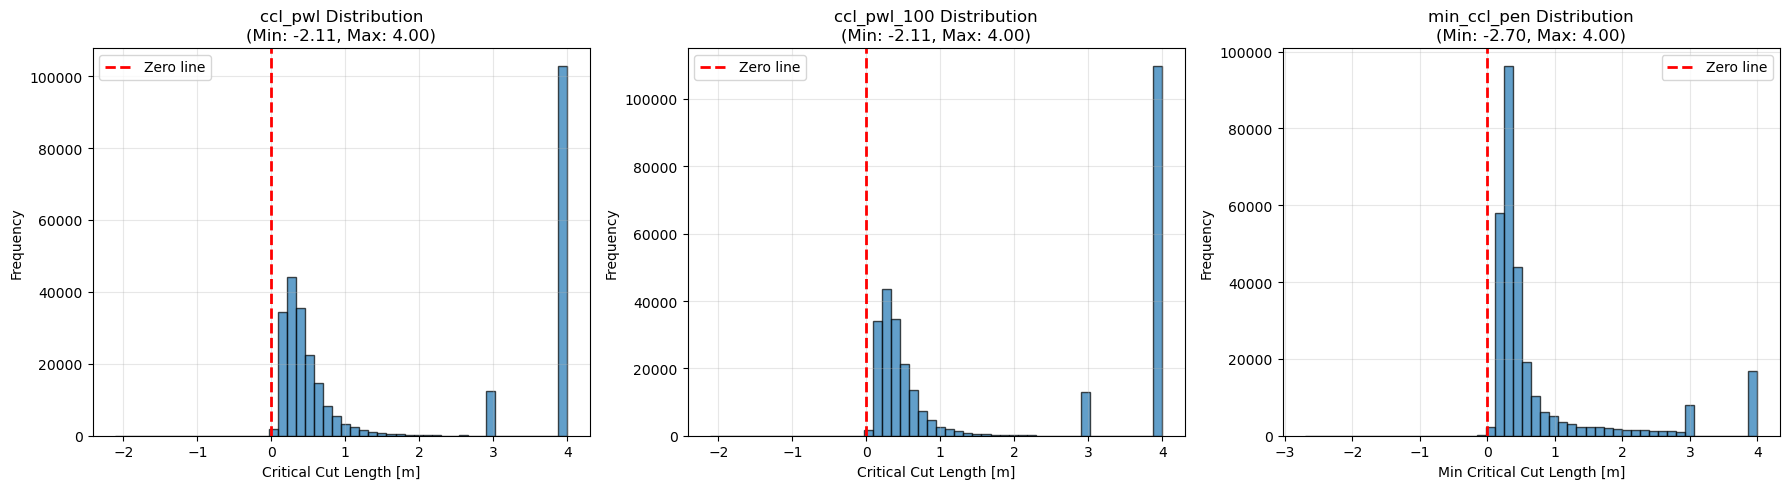

Statistics for negative values:

ccl_pwl:
  Negative values: 86 (0.03%)
  Range of negatives: [-2.110, 0)

ccl_pwl_100:
  Negative values: 68 (0.02%)
  Range of negatives: [-2.110, 0)

min_ccl_pen:
  Negative values: 200 (0.07%)
  Range of negatives: [-2.700, 0)



In [110]:
# Plot distributions of critical cut lengths
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ccl_pwl
axes[0].hist(imis_df['ccl_pwl'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero line')
axes[0].set_xlabel('Critical Cut Length [m]')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'ccl_pwl Distribution\n(Min: {imis_df["ccl_pwl"].min():.2f}, Max: {imis_df["ccl_pwl"].max():.2f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ccl_pwl_100
axes[1].hist(imis_df['ccl_pwl_100'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero line')
axes[1].set_xlabel('Critical Cut Length [m]')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'ccl_pwl_100 Distribution\n(Min: {imis_df["ccl_pwl_100"].min():.2f}, Max: {imis_df["ccl_pwl_100"].max():.2f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# min_ccl_pen
axes[2].hist(imis_df['min_ccl_pen'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[2].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero line')
axes[2].set_xlabel('Min Critical Cut Length [m]')
axes[2].set_ylabel('Frequency')
axes[2].set_title(f'min_ccl_pen Distribution\n(Min: {imis_df["min_ccl_pen"].min():.2f}, Max: {imis_df["min_ccl_pen"].max():.2f})')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics for negative values
print("Statistics for negative values:\n")
for col in ['ccl_pwl', 'ccl_pwl_100', 'min_ccl_pen']:
    negative_count = (imis_df[col] < 0).sum()
    negative_pct = (negative_count / imis_df[col].notna().sum()) * 100
    print(f"{col}:")
    print(f"  Negative values: {negative_count} ({negative_pct:.2f}%)")
    print(f"  Range of negatives: [{imis_df[col].min():.3f}, 0)")
    print()

The negative values are extremely rare. Nevertheless, it is important to impute them, as a model would certainly misinterpret them. I replace negative values with 4, indicating a very stable snowpack. 

Finally, I perform forward-fill imputation for the remaining features with low missingness, ensuring that the dataset is complete and ready for further analysis.

In [111]:
# Replace negative critical cut lengths with 4 
ccl_features = ['ccl_pwl', 'ccl_pwl_100', 'min_ccl_pen']

for col in ccl_features:
    imis_df[col] = imis_df[col].apply(lambda x: 4.0 if x < 0 else x)

for col in ccl_features:
    negative_count = (imis_df[col] < 0).sum()
    print(f"{col}: {negative_count} negative values")

ccl_pwl: 0 negative values
ccl_pwl_100: 0 negative values
min_ccl_pen: 0 negative values


In [112]:
# Forward fill imputation for other features
meteo_features = ['Qg0', 'HN72_24', 'TA', 'HN24', 'TSS_mod']

imis_df = imis_df.sort_values(by=['station_code', 'datum'])

imis_df[meteo_features] = imis_df.groupby('station_code')[meteo_features].ffill()

imis_df[meteo_features] = imis_df.groupby('station_code')[meteo_features].bfill()

print("Forward/backward fill imputation completed for meteorological features")
print(f"\nRemaining missing values:")
for col in meteo_features:
    missing = imis_df[col].isna().sum()
    print(f"{col}: {missing}")

Forward/backward fill imputation completed for meteorological features

Remaining missing values:
Qg0: 0
HN72_24: 0
TA: 0
HN24: 0
TSS_mod: 0


In [113]:
# Check final missing values
total_missing = imis_df.isnull().sum().sum()

if total_missing == 0:
    print("Success: No missing values left")
    print(f"Dataset shape: {imis_df.shape}")
else:
    print(f"Warning: {total_missing} missing values still present")
    print("\nMissing values by feature:")
    missing_summary = imis_df.isnull().sum()
    missing_features = missing_summary[missing_summary > 0].sort_values(ascending=False)
    for col, count in missing_features.items():
        pct = (count / len(imis_df)) * 100
        print(f"  {col}: {count} ({pct:.2f}%)")

Success: No missing values left
Dataset shape: (292837, 69)


For completeness, let's check for duplicate entries & infinite values in the dataset.

In [114]:
# Duplicate Entries & Infinite Values Check
duplicate_count = imis_df.duplicated().sum()
infinite_count = np.isinf(imis_df.select_dtypes(include=[np.number])).sum().sum()   
print(f"Duplicate entries: {duplicate_count}")
print(f"Infinite values: {infinite_count}")

Duplicate entries: 0
Infinite values: 0


## **1.2 Outliers & Erroneous Datapoints**

In this section, I conduct an outlier analysis to identify and handle anomalous data points. I follow the approach of Maissen et al. (2024) and Pérez-Guillén et al. (2022), which rather than using statistical methods like IQR or z-scores, focuses on domain knowledge to define plausible ranges for each feature based on alpine weather conditions.

C:\Users\fabio\AppData\Local\Temp\ipykernel_28056\2646192674.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='dangerLevel', data=imis_df, palette='viridis')


Text(0.5, 1.0, 'Distribution of Avalanche Danger Levels after Preprocessing')

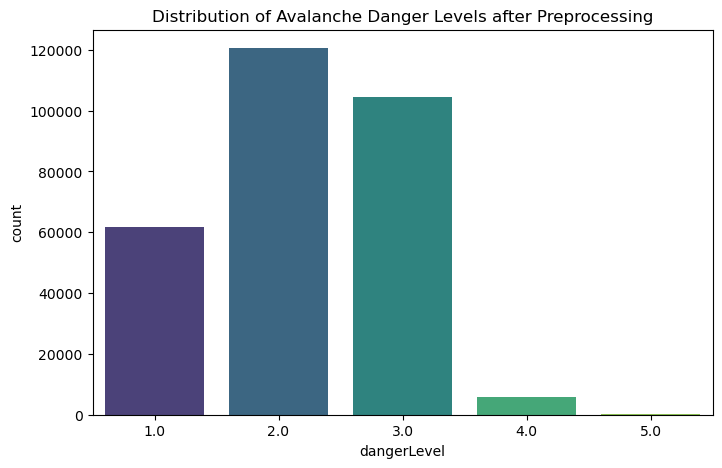

In [115]:
# Distribution of dangerLevel 
plt.figure(figsize=(8, 5))
sns.countplot(x='dangerLevel', data=imis_df, palette='viridis')
plt.title('Distribution of Avalanche Danger Levels after Preprocessing')

Due to the extreme underrepresentation of danger levels 4 and 5, I merge them together into a single class (4/5) for the modeling phase. This helps to ensure that the models have sufficient data to learn from these high-risk categories. This class imbalance issue will also be addressed during model training by using a weighted loss function.

In [116]:
# Merge danger levels 4 and 5
imis_df['dangerLevel'] = imis_df['dangerLevel'].replace({5: 4})

Next, I will look at the highest danger level, and control that only plausible snow conditions are present. Specifically, I discard cases where the 3-day sum of new snow `HN72_24` was less than 30 cm or the total snow depth `HS_mod` was less than 30 cm.

In [117]:
# Filter high danger level 4 cases based on snow conditions
original_dl4_count = (imis_df['dangerLevel'] == 4).sum()
print(f"Original danger level 4 cases: {original_dl4_count}")

high_danger = (imis_df['dangerLevel'] == 4)
snow_conditions = (imis_df['HN72_24'] >= 30) & (imis_df['HS_mod'] >= 30)

# Apply filter
imis_df_filtered = imis_df[~high_danger | (high_danger & snow_conditions)].copy()
remaining_dl4_count = (imis_df_filtered['dangerLevel'] == 4).sum()
removed_dl4 = original_dl4_count - remaining_dl4_count

# Report filtering results
print(f"Original DL4 cases: {original_dl4_count}")
print(f"DL4 cases removed: {removed_dl4} ({removed_dl4/original_dl4_count*100:.2f}%)")
print(f"DL4 cases retained: {remaining_dl4_count} ({remaining_dl4_count/original_dl4_count*100:.2f}%)")
print(f"\nOverall dataset:")
print(f"Total cases before: {len(imis_df)}")
print(f"Total cases after: {len(imis_df_filtered)}")
print(f"Total removed: {len(imis_df) - len(imis_df_filtered)}")

# Update the imis_df
imis_df = imis_df_filtered

Original danger level 4 cases: 6137
Original DL4 cases: 6137
DL4 cases removed: 966 (15.74%)
DL4 cases retained: 5171 (84.26%)

Overall dataset:
Total cases before: 292837
Total cases after: 291871
Total removed: 966


Next, I apply elevation filtering. If for a given day, the forecasted elevation threshold `elevation_th` is greater than the station elevation `elevation_station`, it indicates that the forecast is not applicable to that station's elevation. Therefore, I introduce a new variable `delta_elevation` defined as the difference between `elevation_station` and `elevation_th`. It is negative when the forecast is not applicable to the station.

In [118]:
# Delta Elevation
imis_df['delta_elevation'] = imis_df['elevation_station'] - imis_df['elevation_th']

As meteorological data is heavy-tailed, classical outlier detection methods may not be suitable. Instead, I define plausible ranges for each feature based on domain knowledge of alpine weather conditions. Any data points falling outside these ranges are considered outliers and are removed from the dataset.

In [122]:
# Reasonable physical limits for Swiss Alps winter conditions
swiss_alps_limits = {
    # --- Temperatures (°C) ---
    'TA': (-50.0, 35.0),       # Air temp: rarely above +30 in alpine winter/spring
    'TSS_mod': (-70.0, 50.0),  # Surface temp: can get very hot in sun, very cold at night
    'TSS_meas': (-70.0, 50.0), # Same for measured
    'TSG': (-30.0, 30.0),      # Ground temp: usually stable near 0 under snow, but can vary if bare
    # Note: TS0, TS1, TS2 excluded as you plan to drop them

    # --- Radiation (W/m²) ---
    'ISWR': (-10.0, 1600.0),   # Incoming Shortwave: solar constant ~1360. Small neg values possible due to sensor noise at night.
    'OSWR': (-10.0, 1600.0),   # Reflected Shortwave: cannot exceed incoming (physically), but snow can reflect a lot.
    'ILWR': (50.0, 600.0),     # Incoming Longwave: derived from sky temp/clouds.
    'OLWR': (50.0, 800.0),     # Outgoing Longwave: derived from surface temp.
    'LWR_net': (-300.0, 100.0),# Net Longwave: usually negative at night (cooling).
    'Qg0': (-500.0, 500.0),    # Ground Heat Flux: small compared to radiation. >500 is definitely wrong.
    'Qs': (-600.0, 600.0),     # Sensible Heat Flux
    'Ql': (-600.0, 600.0),     # Latent Heat Flux

    # --- Moisture & Precipitation ---
    'RH': (0.0, 105.0),        # Relative Humidity (%): allow slight sensor drift >100%
    'MS_Rain': (0.0, 100.0),   # Rain rate (kg/m²/h): >100mm/h is tropical storm level, unlikely in winter Alps.
    'MS_Snow': (0.0, 100.0),   # Snow water equivalent rate (kg/m²/h)

    # --- Wind ---
    'VW': (0.0, 85.0),         # Wind Speed (m/s): 85 m/s is ~300 km/h (extreme hurricane force peaks possible on ridges)
    'VW_drift': (0.0, 85.0),   # Drifting wind speed

    # --- Snowpack (cm) ---
    'HS_meas': (0.0, 1500.0),  # Measured Snow Height: 15m is a safe upper bound for deepest drifts.
    'HS_mod': (0.0, 1500.0),   # Modelled Snow Height
    'HN24': (0.0, 250.0),      # 24h New Snow: >2.5m in 24h is extremely unlikely.
    'HN72_24': (0.0, 500.0),   # 3-day New Snow sum
    'wind_trans24': (0.0, 1000.0) # 24h Wind Drifted Snow: can be very high in drift zones.
}

In [124]:
import pandas as pd
import numpy as np

def find_physical_violations(df, limits=None):
    """
    Checks specific features against hard physical limits to identify broken sensors.
    """
    # Default physical limits for Swiss Alps (winter/spring)
    if limits is None:
        limits = {
            # --- Temperatures (°C) ---
            'TA': (-50.0, 40.0),
            'TSS_mod': (-70.0, 60.0),
            'TSS_meas': (-70.0, 60.0),
            'TSG': (-30.0, 30.0),
            'T_bottom': (-30.0, 30.0),
            
            # --- Radiation & Heat Flux (W/m²) ---
            'ISWR': (-10.0, 1600.0),
            'OSWR': (-10.0, 1600.0),
            'ILWR': (10.0, 800.0),
            'OLWR': (10.0, 800.0),
            'LWR_net': (-500.0, 500.0),
            'Qg0': (-500.0, 500.0),
            'Qs': (-1000.0, 1000.0),
            'Ql': (-1000.0, 1000.0),
            'pAlbedo': (-0.1, 1.1), 
            
            # --- Moisture & Precip ---
            'RH': (-5.0, 105.0),
            'MS_Rain': (-0.1, 200.0),
            'MS_Snow': (-0.1, 200.0),
            'MS_water': (-0.1, 1000.0), # Total water can be high but not negative
            
            # --- Wind (m/s) ---
            'VW': (-0.1, 100.0),
            'VW_drift': (-0.1, 100.0),
            
            # --- Snowpack (cm) ---
            'HS_meas': (-5.0, 1500.0),
            'HS_mod': (-1.0, 1500.0),
            'HN24': (-1.0, 400.0),
            'HN72_24': (-1.0, 600.0),
            'wind_trans24': (-1.0, 1500.0), # Drifts can be huge
            'SWE': (-1.0, 2000.0)           # Snow Water Equivalent
        }

    violations = []

    for col, (min_val, max_val) in limits.items():
        if col not in df.columns: continue
            
        # Check MIN
        lower_mask = df[col] < min_val
        if lower_mask.any():
            # Extract data efficiently
            violation_data = df.loc[lower_mask, ['datum', 'station_code', col]].copy()
            violation_data.columns = ['Date', 'Station', 'Value']
            violation_data['Feature'] = col
            violation_data['Violation'] = f"Below Min ({min_val})"
            violations.append(violation_data)

        # Check MAX
        upper_mask = df[col] > max_val
        if upper_mask.any():
            violation_data = df.loc[upper_mask, ['datum', 'station_code', col]].copy()
            violation_data.columns = ['Date', 'Station', 'Value']
            violation_data['Feature'] = col
            violation_data['Violation'] = f"Above Max ({max_val})"
            violations.append(violation_data)

    if not violations:
        return pd.DataFrame()
    
    return pd.concat(violations, ignore_index=True)

# --- EXECUTION ---
broken_sensor_report = find_physical_violations(imis_df)

if not broken_sensor_report.empty:
    print(f"Found {len(broken_sensor_report)} Physical Violations.\n")
    
    # Group by Station AND Feature to see specifically WHICH sensors on WHICH stations are broken
    sensor_summary = broken_sensor_report.groupby(['Station', 'Feature', 'Violation'])['Value'].agg(
        Error_Count='count',
        Min_Err_Val='min',
        Max_Err_Val='max'
    ).reset_index().sort_values('Error_Count', ascending=False)

    print("Broken Sensor Diagnostic Table (Top 40):")
    print(sensor_summary.head(40).to_string(index=False))
else:
    print("No physical violations found with current limits.")

Found 719 Physical Violations.

Broken Sensor Diagnostic Table (Top 40):
Station Feature           Violation  Error_Count  Min_Err_Val  Max_Err_Val
   BED2     SWE  Above Max (2000.0)          136  2011.525500  2587.627125
   BOR2     SWE  Above Max (2000.0)           87  2000.096875  2971.200500
   VIN2     Qg0   Above Max (500.0)           60   660.319500  4175.294333
   TRU2     SWE  Above Max (2000.0)           48  2027.276000  2603.304750
   GAN2     SWE  Above Max (2000.0)           47  2007.941125  2456.814125
   RNZ2     SWE  Above Max (2000.0)           43  2013.879500  2331.734000
   SIM2     Qg0   Above Max (500.0)           36   871.325625  1221.167250
   LUK2     SWE  Above Max (2000.0)           34  2018.836250  2307.649000
   FOU2     SWE  Above Max (2000.0)           31  2020.511875  2441.649500
   FOU2     Qg0   Above Max (500.0)           29   604.213125   938.488667
   BOV2     Qg0   Above Max (500.0)           25  1179.606125  8995.528000
   OFE2     Qg0   Above Max

In [126]:
imis_df.columns

Index(['datum', 'station_code', 'sector_id', 'warnreg', 'elevation_station',
       'forecast_initial_date', 'forecast_end_date', 'dangerLevel',
       'elevation_th', 'set', 'Qs', 'Ql', 'Qg0', 'Qr', 'OLWR', 'ILWR',
       'LWR_net', 'OSWR', 'ISWR', 'Qw', 'pAlbedo', 'ISWR_h', 'ISWR_diff',
       'ISWR_dir', 'TA', 'TSS_mod', 'RH', 'VW', 'VW_drift', 'DW', 'MS_Snow',
       'HS_mod', 'HS_meas', 'hoar_size', 'wind_trans24', 'wind_trans24_7d',
       'wind_trans24_3d', 'HN24', 'HN72_24', 'HN24_7d', 'SWE', 'MS_water',
       'MS_Wind', 'MS_Rain', 'MS_SN_Runoff', 'MS_Sublimation', 'MS_Evap',
       'Sclass2', 'zSd_mean', 'Sd', 'zSn', 'Sn', 'zSs', 'Ss', 'zS4', 'S4',
       'zS5', 'ssi_pwl', 'sk38_pwl', 'sn38_pwl', 'ccl_pwl', 'ssi_pwl_100',
       'sk38_pwl_100', 'sn38_pwl_100', 'ccl_pwl_100', 'Pen_depth',
       'min_ccl_pen', 'lon', 'lat', 'delta_elevation'],
      dtype='object')

In [ ]:
import pandas as pd
import numpy as np

def find_physical_violations(df, limits=None):
    """
    Checks specific features against hard physical limits to identify broken sensors.
    """
    if limits is None:
        limits = {
            # Temperatures (°C)
            'TA': (-50.0, 40.0),
            'TSS_mod': (-70.0, 60.0),
            'TSS_meas': (-70.0, 60.0),
            'TSG': (-30.0, 30.0),
            'T_bottom': (-30.0, 30.0),
            
            # --- Radiation & Heat Flux (W/m²) ---
            'ISWR': (-10.0, 1600.0),
            'OSWR': (-10.0, 1600.0),
            'ILWR': (10.0, 800.0),
            'OLWR': (10.0, 800.0),
            'LWR_net': (-500.0, 500.0),
            'Qg0': (-500.0, 500.0),
            'Qs': (-1000.0, 1000.0),
            'Ql': (-1000.0, 1000.0),
            'pAlbedo': (-0.1, 1.1), 
            
            # --- Moisture & Precip ---
            'RH': (-5.0, 105.0),
            'MS_Rain': (-0.1, 200.0),
            'MS_Snow': (-0.1, 200.0),
            'MS_water': (-0.1, 1000.0), # Total water can be high but not negative
            
            # --- Wind (m/s) ---
            'VW': (-0.1, 100.0),
            'VW_drift': (-0.1, 100.0),
            
            # --- Snowpack (cm) ---
            'HS_meas': (-5.0, 1500.0),
            'HS_mod': (-1.0, 1500.0),
            'HN24': (-1.0, 400.0),
            'HN72_24': (-1.0, 600.0),
            'wind_trans24': (-1.0, 1500.0), # Drifts can be huge
            'SWE': (-1.0, 2000.0)           # Snow Water Equivalent
        }

    violations = []
    for col, (min_val, max_val) in limits.items():
        if col not in df.columns: continue
        
        # Efficiently find violations using boolean indexing
        lower = df[col] < min_val
        upper = df[col] > max_val
        
        if lower.any():
            v_data = df.loc[lower, ['datum', 'station_code', col]].copy()
            v_data.columns = ['Date', 'Station', 'Value']
            v_data['Feature'] = col
            v_data['Violation'] = f"Below Min ({min_val})"
            violations.append(v_data)
            
        if upper.any():
            v_data = df.loc[upper, ['datum', 'station_code', col]].copy()
            v_data.columns = ['Date', 'Station', 'Value']
            v_data['Feature'] = col
            v_data['Violation'] = f"Above Max ({max_val})"
            violations.append(v_data)

    if not violations:
        return pd.DataFrame()
    return pd.concat(violations, ignore_index=True)

# --- EXECUTION & REPORTING ---
broken_sensor_report = find_physical_violations(imis_df)

if not broken_sensor_report.empty:
    print(f"Found {len(broken_sensor_report)} Physical Violations.\n")
    
    # 1. Summary by Feature (Where are the problems?)
    feature_summary = broken_sensor_report.groupby(['Feature', 'Violation']).size().reset_index(name='Count')
    print("--- Violation Summary by Feature ---")
    print(feature_summary.to_string(index=False))
    print("\n")

Found 719 Physical Violations.

--- Violation Summary by Feature ---
Feature           Violation  Count
MS_Rain   Above Max (200.0)      1
    Qg0   Above Max (500.0)    256
     Ql Below Min (-1000.0)      1
    SWE  Above Max (2000.0)    461


--- Top 40 Broken Sensor Diagnostics ---
Station Feature           Violation  Error_Count  Min_Err_Val  Max_Err_Val
   BED2     SWE  Above Max (2000.0)          136  2011.525500  2587.627125
   BOR2     SWE  Above Max (2000.0)           87  2000.096875  2971.200500
   VIN2     Qg0   Above Max (500.0)           60   660.319500  4175.294333
   TRU2     SWE  Above Max (2000.0)           48  2027.276000  2603.304750
   GAN2     SWE  Above Max (2000.0)           47  2007.941125  2456.814125
   RNZ2     SWE  Above Max (2000.0)           43  2013.879500  2331.734000
   SIM2     Qg0   Above Max (500.0)           36   871.325625  1221.167250
   LUK2     SWE  Above Max (2000.0)           34  2018.836250  2307.649000
   FOU2     SWE  Above Max (2000.0)   